In [124]:
import sys
sys.path.append('../lib/BioInfer_software_1.0.1_Python3/')
sys.path.append('../py/')
from BIParser import BIParser

import os
import json
os.environ['DGL_BACKEND'] = "pytorch" 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import dgl
import torch as th
import torch.nn as nn

from collections import Counter, OrderedDict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
parser = BIParser()

In [3]:
with open('../data/BioInfer_corpus_1.1.1.xml','r') as f:
    parser.parse(f)

In [226]:
from config import ENTITY_PREFIX, PREDICATE_PREFIX

## Extract BioInfer data

In [5]:
texts = []
BIO_labels = []
tuple_labels = []


sentences = parser.bioinfer.sentences.sentences
for s in sentences:
    tokens = [t.getText() for t in s.tokens]
    
    # initialize Beginning Inside Outside (BIO) encoding for entities, maybe useful if we want to add NER as joint task
    NER_labels = ['O' for t in s.tokens] 
    
    # GET DISJOINT SETS OF NESTED AND TOP-LEVEL ENTITIES
    nested_entities = set()
    for e in s.entities:
        for n in e.nestedEntities:
            nested_entities.add(n)

    top_level_entities = set()
    for e in s.entities:
        if e not in nested_entities:
            top_level_entities.add(e)
    
    #check that sets are disjoint and cover the full set of entities in the sentence
    disjoint = len(nested_entities.intersection(top_level_entities)) == 0
    matching_len = len(nested_entities) + len(top_level_entities) == len(s.entities)
    assert disjoint and matching_len
    
    # CREATE TUPLES OF (<entity_class>, (<entity_token_1>,<entity_token_2>,...)
    # note that this ignores labels starting with "RELATIONSHIP_"
    entity_tuples = []
    
    for e in nested_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))
            
    for e in top_level_entities:
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            entity_tuples.append((entity_type,tuple([st.token.sequence for st in e.subTokens])))    
    
    # PERFORM BIO ENCODING FOR TOP-LEVEL ENTITIES
    for e in top_level_entities:
        prefix = 'B-'
        entity_type = e.type.name
        if 'RELATIONSHIP' not in entity_type:
            for t in list(OrderedDict.fromkeys([st.token for st in e.subTokens])):
                NER_labels[t.sequence] = prefix + entity_type
                prefix = 'I-'
                
    texts.append(tokens)
    BIO_labels.append(NER_labels)
    tuple_labels.append(entity_tuples)

#### inspect results

In [6]:
texts[0]

['alpha-catenin',
 'inhibits',
 'beta-catenin',
 'signaling',
 'by',
 'preventing',
 'formation',
 'of',
 'a',
 'beta-catenin*T-cell',
 'factor*DNA',
 'complex',
 '.']

In [7]:
tuple_labels[0]

[('Individual_protein', (2,)),
 ('Individual_protein', (9,)),
 ('Individual_protein', (9, 10)),
 ('Individual_protein', (0,)),
 ('Function_property', (2, 3)),
 ('Protein_complex', (9, 9, 9, 10, 10, 11))]

In [8]:
BIO_labels[0]

['B-Individual_protein',
 'O',
 'B-Function_property',
 'I-Function_property',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Protein_complex',
 'I-Protein_complex',
 'I-Protein_complex',
 'O']

## Extract BioInfer metadata

In [126]:
def get_relnode_argument_types(relnode):
    arguments = set()
    for a in relnode.arguments:
        if a.isEntity():
            arguments.add(f"{ENTITY_PREFIX}{a.entity.type.name}")
        elif a.isPredicate():
            arguments.add(f"{PREDICATE_PREFIX}{a.predicate.name}")
        else:
            raise ValueError
        
    return tuple(sorted(list(arguments)))

Get BioInfer task configuration

In [215]:
configuration = {}

for s in parser.bioinfer.sentences.sentences:
    for f in s.formulas:
        if f.rootNode.isPredicate():
            predicate_name = f.rootNode.predicate.name
            if predicate_name not in configuration.keys():
                configuration[predicate_name] = Counter()
            arguments = ','.join(get_relnode_argument_types(f.rootNode))
            configuration[predicate_name][arguments] += 1
        elif f.rootNode.isEntity():
            print(f)

In [132]:
with open('../data/configuration.json','w') as f:
    json.dump(configuration,f)

Get BioInfer entity-to-index lookup dict

In [163]:
entities = set() 
for rel, argsets in configuration.items():
    for argset in argsets:
        for arg in argset.split(','):
            if ENTITY_PREFIX in arg:
                entities.add(arg.replace(ENTITY_PREFIX,''))
entities = list(entities)

entities_to_idx = {entities[i]:i for i in range(len(entities))}

In [161]:
with open('../data/entities.json','w') as f:
    json.dump(entities_to_idx,f)

Get BioInfer relation-to-index lookup dict

In [167]:
relations = list(configuration.keys())

relations_to_idx = {relations[i]:i for i in range(len(relations))}

In [169]:
with open('../data/relations.json','w') as f:
    json.dump(relations_to_idx,f)

## Figures

In [217]:
config_df = pd.DataFrame(configuration)

How many relations in the data?

In [220]:
config_df.sum().sum()

2550.0

<AxesSubplot:>

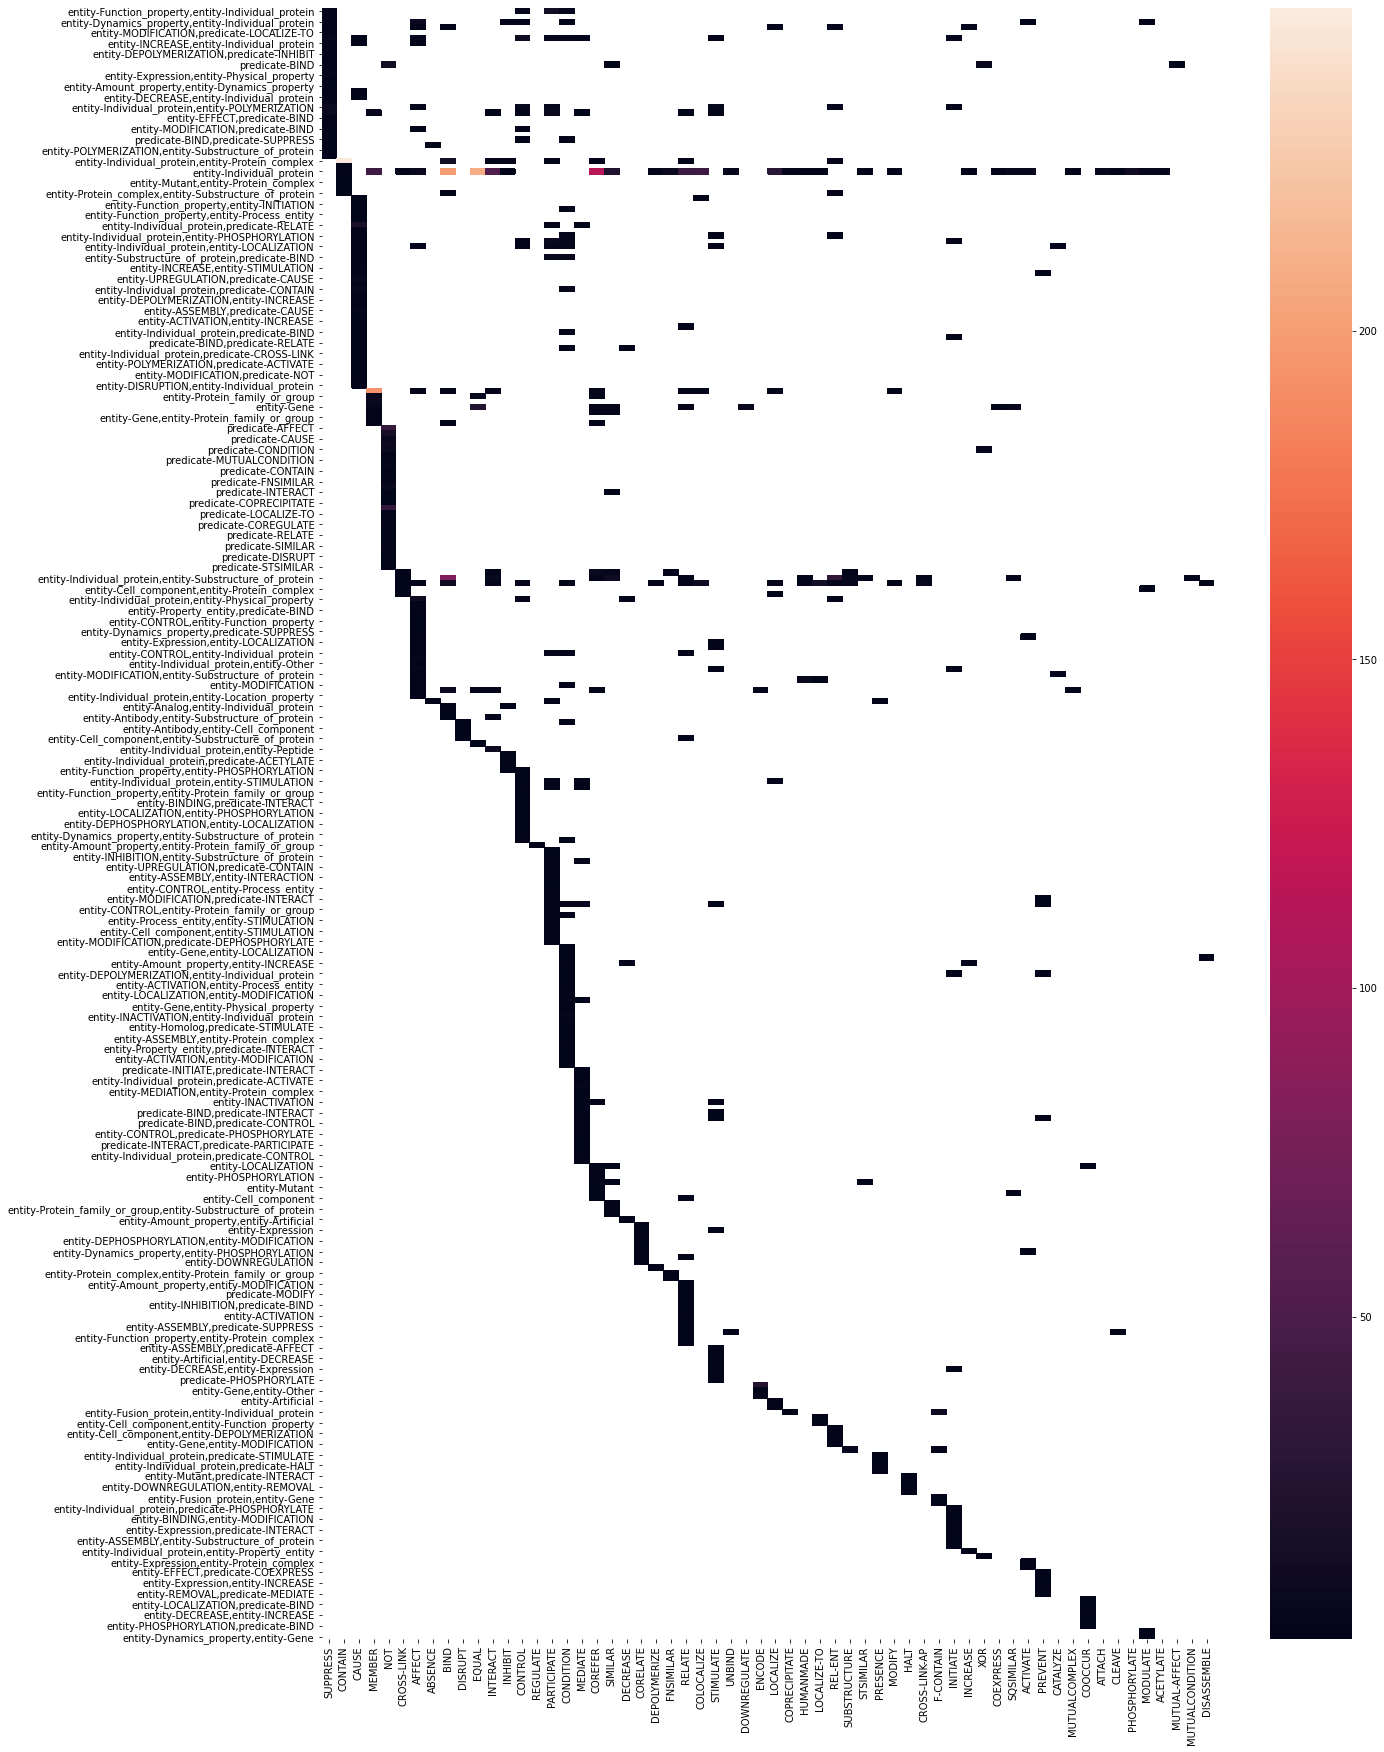

In [221]:
ax, fig = plt.subplots(1,figsize=(20,30))
sns.heatmap(config_df)

How many relation predicates?

In [214]:
len(relation_types)

60

In [ ]:
relation_types = config_df.sum().sort_values(ascending=False)

relation_types.sum() * 0.9


relation_types.head(10).sum() / relation_types.sum()

relation_types

<AxesSubplot:>

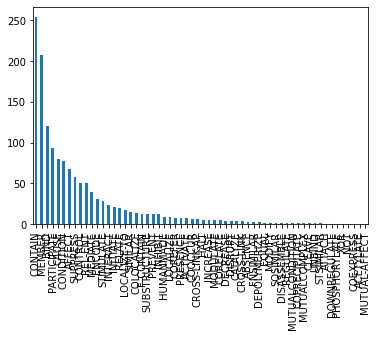

In [89]:
relation_types.plot.bar()